## Darlene Phan
July 8, 2022<br>
My first project

### Data Exploration

#### Imports were updated as needed, but wanted to keep all the imports centralized for easy viewing. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')

In [2]:
sales = pd.read_csv('Data/sales_predictions (2).csv')

In [3]:
#Renamed columns so they're eaiser to read, shortened or makes them easy to reference later in the code. 
rename = {'Item_Identifier': 'item_id',
'Item_Weight': 'item_weight',
'Item_Fat_Content': 'item_fat_content',
'Item_Visibility': 'item_visibility',
'Item_Type': 'item_type',
'Item_MRP': 'mrp',
'Outlet_Identifier': 'outlet_id',
'Outlet_Establishment_Year': 'est_year',
'Outlet_Size': 'outlet_size',
'Outlet_Location_Type': 'loc_type',
'Outlet_Type': 'outlet_type',
'Item_Outlet_Sales': 'item_sales'
}
sales.rename(columns=rename, inplace=True)
sales.head()

,item_id,item_weight,item_fat_content,item_visibility,item_type,mrp,outlet_id,est_year,outlet_size,loc_type,outlet_type,item_sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#checking for duplicates
sales.duplicated().sum()

0

In [5]:
#Checking for missing values in the data
sales.isna().sum()

item_id                0
item_weight         1463
item_fat_content       0
item_visibility        0
item_type              0
mrp                    0
outlet_id              0
est_year               0
outlet_size         2410
loc_type               0
outlet_type            0
item_sales             0
dtype: int64

In [6]:
# Seeing the overall shape of the data
sales.shape

(8523, 12)

In [7]:
# Checking object types and confirming missing values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_id           8523 non-null   object 
 1   item_weight       7060 non-null   float64
 2   item_fat_content  8523 non-null   object 
 3   item_visibility   8523 non-null   float64
 4   item_type         8523 non-null   object 
 5   mrp               8523 non-null   float64
 6   outlet_id         8523 non-null   object 
 7   est_year          8523 non-null   int64  
 8   outlet_size       6113 non-null   object 
 9   loc_type          8523 non-null   object 
 10  outlet_type       8523 non-null   object 
 11  item_sales        8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Dropping Columns
Based on the data exploration, the item weight cateogry has 17% data missing overall. Unfortunately, that is a lot more than the standard for which we should be imputing data. I also believe that item weight does not contribute much to the item sales themselves, therefore that column will be dropped. 

Outlet size is also going to be dropped since it is missing 28% of the data. However, there are other metrics to measure the size of the establishment. So we can move forth with removing this slightly redundant column.

Note - We could impute data here, that is an option. However, there is so much missing data that imputing would drastically skew our model, thus rendering our Machine Learning model ineffective. 

In [8]:
sales = sales.drop(columns=['item_weight','outlet_size'])

In [9]:
sales.isnull().sum()

item_id             0
item_fat_content    0
item_visibility     0
item_type           0
mrp                 0
outlet_id           0
est_year            0
loc_type            0
outlet_type         0
item_sales          0
dtype: int64

In [10]:
#adjusting categorical errors
sales['item_fat_content'] = sales['item_fat_content'].replace('LF', 'Low Fat')
sales['item_fat_content'] = sales['item_fat_content'].replace('low fat', 'Low Fat')
sales['item_fat_content'] = sales['item_fat_content'].replace('reg', 'Regular')
sales.item_fat_content.unique()

array(['Low Fat', 'Regular'], dtype=object)

In [11]:
#Generating statistical data
sales.describe() 

,item_visibility,mrp,est_year,item_sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,0.066132,140.992782,1997.831867,2181.288914
std,0.051598,62.275067,8.371760,1706.499616
min,0.000000,31.290000,1985.000000,33.290000
25%,0.026989,93.826500,1987.000000,834.247400
50%,0.053931,143.012800,1999.000000,1794.331000
75%,0.094585,185.643700,2004.000000,3101.296400
max,0.328391,266.888400,2009.000000,13086.964800


### Creating copy of dataframe. 
This prevents data leakage for when we prep the model for machine learning. 

In [12]:
ml_sales = sales.copy()

### Data Exploration Through Visualization
This first part of the data visualization I will be using some univariate graphs. This allows us to see a distribution of data from a single variable. 

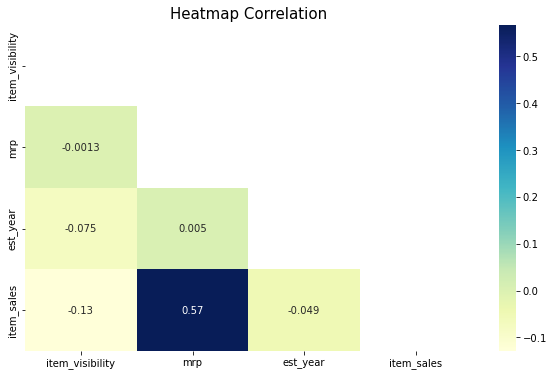

In [13]:
#Heatmap visually displays the correlation (relatioinship) between the numerical data points.
#This helps us determine which variables we should be focusing on.
corr = sales.corr()
plt.figure(figsize=(10,6))
matrix = np.triu(corr)
ax = sns.heatmap(corr, annot=True, cmap="YlGnBu", mask=matrix)
plt.title('Heatmap Correlation', fontsize=15)
plt.show()

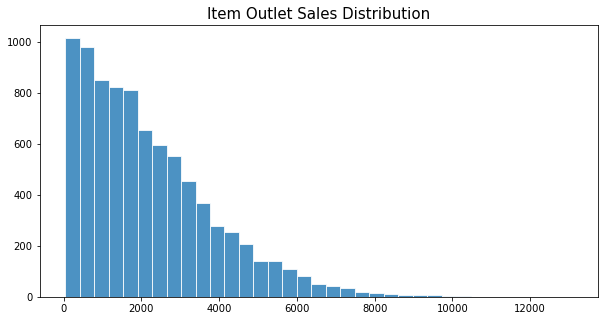

In [14]:
#This historgram displays the item sales distribution
plt.figure(figsize=(10,5))
plt.hist(sales['item_sales'], alpha=.8, bins=35, edgecolor='w')
plt.title('Item Outlet Sales Distribution', fontsize=15)
plt.show()

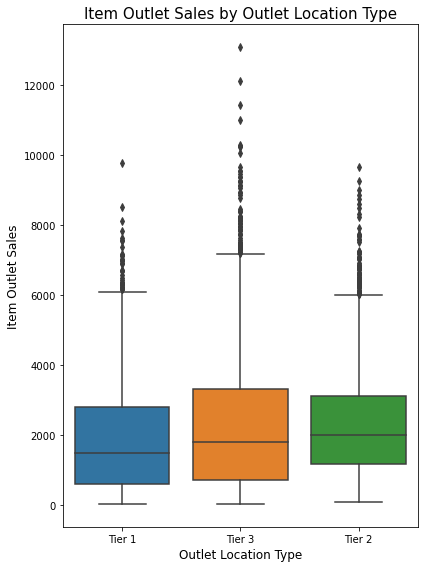

In [15]:
#Boxplot 
plt.figure(figsize=(6,8))
sns.boxplot(data=sales, x='loc_type', y='item_sales')
plt.title('Item Outlet Sales by Outlet Location Type', fontsize=15)
plt.xlabel('Outlet Location Type', fontsize=12)
plt.ylabel('Item Outlet Sales', fontsize=12)
plt.tight_layout()
plt.show()

### Multivariate Visualizations
These allow us to see the relationships between multiple variables simulataneously

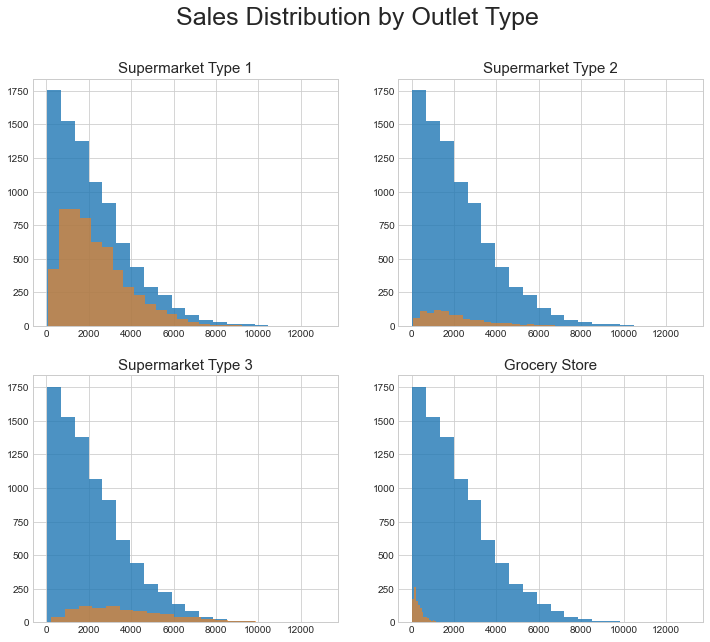

In [16]:
type1 = sales[sales['outlet_type'] == 'Supermarket Type1']['item_sales']
type2 = sales[sales['outlet_type'] == 'Supermarket Type2']['item_sales']
type3 = sales[sales['outlet_type'] == 'Supermarket Type3']['item_sales']
grocery_store = sales[sales['outlet_type'] == 'Grocery Store']['item_sales']

plt.style.use('seaborn-whitegrid')
sequential_colors = sns.color_palette("mako", 10)

plt.figure(figsize=(12,10))
plt.suptitle('Sales Distribution by Outlet Type', fontsize=25)

plt.subplot(2,2,1)
plt.hist(sales['item_sales'], alpha=.8, label = 'Total Item Sales', bins=20)
plt.hist(type1, alpha=.6, label='Supermarket Type 1', bins=20)
plt.title('Supermarket Type 1', fontsize=15)

plt.subplot(2,2,2)
plt.hist(sales['item_sales'], alpha=.8, label = 'Total Item Sales', bins=20)
plt.hist(type2, alpha=.6, label='Supermarket Type 2', bins=20)
plt.title('Supermarket Type 2', fontsize=15)

plt.subplot(2,2,3)
plt.hist(sales['item_sales'], alpha=.8, label = 'Total Item Sales', bins=20)
plt.hist(type3, alpha=.6, label='Supermarket Type 3', bins=20)
plt.title('Supermarket Type 3', fontsize=15)

plt.subplot(2,2,4)
plt.hist(sales['item_sales'], alpha=.8, label = 'Total Item Sales', bins=20)
plt.hist(grocery_store, alpha=.6, label='Grocery Store', bins=20)
plt.title('Grocery Store', fontsize=15)


plt.show()

Histrogram of Sales Distribution by Outlet type shows which type of outlets generate the most sales compared to the overall sales. 

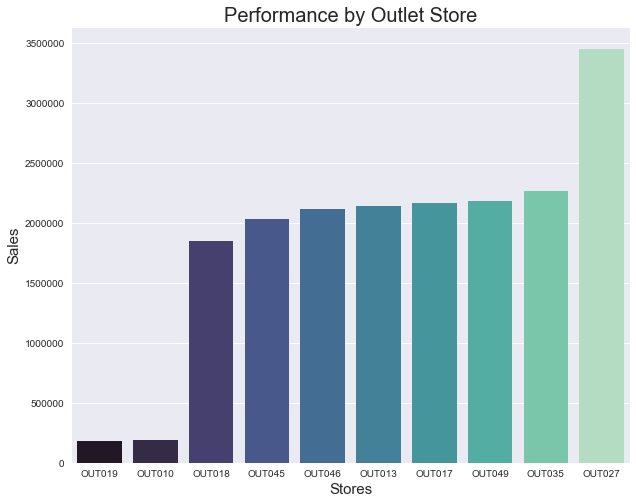

In [17]:
outlet_sales = sales.groupby(['outlet_type', 'outlet_id'])['item_sales'].sum().sort_values()
outlet_sales = outlet_sales.to_frame().reset_index()

sequential_colors = sns.color_palette("mako", 10)
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=outlet_sales, x='outlet_id', y='item_sales', ci=None, palette=sequential_colors)
plt.title('Performance by Outlet Store', fontsize=20)

plt.xlabel('Stores', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0))

plt.show()

Performance by Outlet Store, gives you a deeper dive on which stores perform well compared to the ones that do not. When 70% of the stores perform within range of one another, we also have 20% that are performing well below the average. 

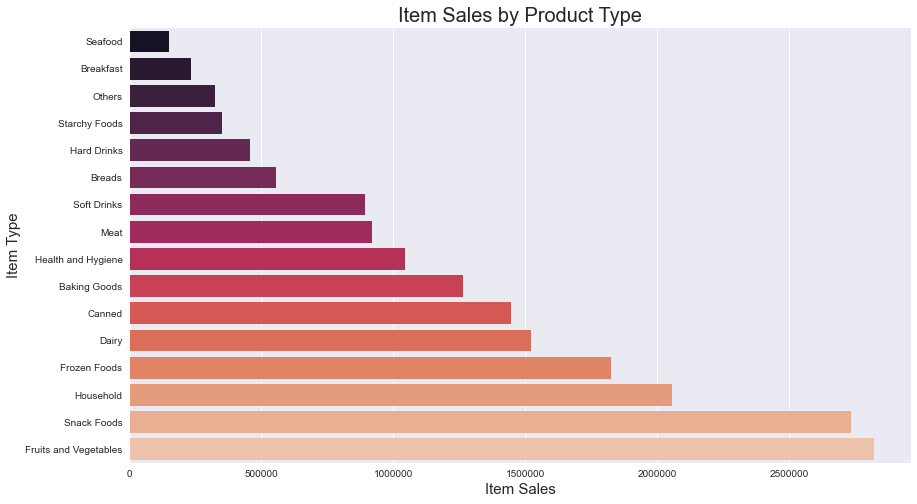

In [18]:
item_sales = sales.groupby('item_type')['item_sales'].sum().to_frame().reset_index().sort_values('item_sales')

sequential_colors = sns.color_palette("rocket", 17)
plt.figure(figsize=(14,8))

ax = sns.barplot(data=item_sales, y='item_type', x='item_sales', ci=None, palette=sequential_colors)
plt.title('Item Sales by Product Type', fontsize=20)

plt.ylabel('Item Type', fontsize=15)
plt.xlabel('Item Sales', fontsize=15)
current_values = plt.gca().get_xticks()
plt.ticklabel_format(axis="x", style="plain", scilimits=(0,0))

plt.show()

Item Sales by Product Type, a comprehensive look at what products actually sell well, vs ones that do not. 

### Prepping for Machine Learning

Identify X features and Y target. Splitting the data into train, test, split. 

In [19]:
X = ml_sales.drop(columns = ['item_sales', 'est_year', 'item_id', 'outlet_id'])
y  = ml_sales['item_sales']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,item_fat_content,item_visibility,item_type,mrp,loc_type,outlet_type
4776,Low Fat,0.029565,Household,256.4646,Tier 3,Supermarket Type2
7510,Regular,0.000000,Snack Foods,179.7660,Tier 3,Supermarket Type2
5828,Regular,0.158716,Meat,157.2946,Tier 1,Supermarket Type1
5327,Low Fat,0.014628,Baking Goods,82.3250,Tier 2,Supermarket Type1
4810,Low Fat,0.016645,Frozen Foods,120.9098,Tier 2,Supermarket Type1
...,...,...,...,...,...,...
5734,Regular,0.286345,Fruits and Vegetables,139.1838,Tier 3,Grocery Store
5191,Low Fat,0.117575,Frozen Foods,75.6670,Tier 2,Supermarket Type1
5390,Low Fat,0.018944,Health and Hygiene,237.3590,Tier 2,Supermarket Type1
860,Low Fat,0.054363,Snack Foods,117.9466,Tier 2,Supermarket Type1


### Machine Learning Preprocessing Steps

In [20]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [21]:
#One-Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#scaler
scaler = StandardScaler()

In [22]:
#Numeric Pipeline
numeric_pipe = make_pipeline(scaler)

#Categorical Pipeline
categorical_pipe = make_pipeline(ohe)

In [23]:
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)

#ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5cd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5be0>)])

### Fitting the Transformer then transforming our X_test and X_train

In [24]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5cd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5be0>)])

In [25]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Inpsecting our transformation results

In [26]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')

X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64




array([[-0.71277507,  1.82810922,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

### Regression Evaluation Function

In [27]:
def eval_regression(true, pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    return [rmse, r2]

### Linear Regression Model

In [28]:
#confirming our dataframe
X_train

,item_fat_content,item_visibility,item_type,mrp,loc_type,outlet_type
4776,Low Fat,0.029565,Household,256.4646,Tier 3,Supermarket Type2
7510,Regular,0.000000,Snack Foods,179.7660,Tier 3,Supermarket Type2
5828,Regular,0.158716,Meat,157.2946,Tier 1,Supermarket Type1
5327,Low Fat,0.014628,Baking Goods,82.3250,Tier 2,Supermarket Type1
4810,Low Fat,0.016645,Frozen Foods,120.9098,Tier 2,Supermarket Type1
...,...,...,...,...,...,...
5734,Regular,0.286345,Fruits and Vegetables,139.1838,Tier 3,Grocery Store
5191,Low Fat,0.117575,Frozen Foods,75.6670,Tier 2,Supermarket Type1
5390,Low Fat,0.018944,Health and Hygiene,237.3590,Tier 2,Supermarket Type1
860,Low Fat,0.054363,Snack Foods,117.9466,Tier 2,Supermarket Type1


### Prepping our data for our Linear Regression model

In [29]:
#Linear Regression model
reg = LinearRegression()

#Create Pipeline
reg_pipeline = make_pipeline(preprocessor, reg)

In [30]:
#Fit the pipeline on to training data
reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5cd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5be0>)])),
                ('linearregression', LinearRegression())])

In [31]:
#Checking predictions
predictions = reg_pipeline.predict(X_test)
predictions

array([1350.53989015,  769.49265814,  835.27877997, ..., 3404.08440699,
       1963.86080115, 2435.52430251])

In [32]:
#Pushing predictions to dataframe for eaiser viewing. 
#Created an error column to display the difference from true item sale and predicted
prediction_df = X_test.copy()
prediction_df['True Item Sale Price'] = y_test
prediction_df['Predicted Item Sale Price'] = predictions
prediction_df['Error'] = predictions - y_test
prediction_df.head()

,item_fat_content,item_visibility,item_type,mrp,loc_type,outlet_type,True Item Sale Price,Predicted Item Sale Price,Error
7503,Low Fat,0.026300,Frozen Foods,79.4302,Tier 3,Supermarket Type1,1743.0644,1350.539890,-392.524510
2957,Low Fat,0.071136,Health and Hygiene,42.7086,Tier 1,Supermarket Type1,356.8688,769.492658,412.623858
7031,Regular,0.041313,Canned,42.0454,Tier 1,Supermarket Type1,377.5086,835.278780,457.770180
1084,Regular,0.044767,Soft Drinks,173.7054,Tier 3,Supermarket Type3,5778.4782,4235.522246,-1542.955954
856,Regular,0.012456,Meat,197.5110,Tier 2,Supermarket Type1,2356.9320,3258.974203,902.042203


### Linear Regression  - Regression Metrics

In [33]:
reg_train_score= eval_regression(y_train, reg_pipeline.predict(X_train))
reg_test_score = eval_regression(y_test, reg_pipeline.predict(X_test))
print('Regression Tree Training Results')
print(f'RMSE Score: {reg_train_score[0]}')
print(f'R^2 Score: {reg_train_score[1]}')
print('\n')
print('Regression Tree Testing Results')
print(f'RMSE Score:  {reg_test_score[0]}')
print(f'R^2 Score: {reg_test_score[1]}')

Regression Tree Training Results
RMSE Score: 1140.4177004801268
R^2 Score: 0.5605433358643774


Regression Tree Testing Results
RMSE Score:  1094.4486751815027
R^2 Score: 0.5658471318700873


### Regression Tree Model
Prepping our data for our next Machine Learning model

In [34]:
#Decision Tree Model
dec_tree = DecisionTreeRegressor(random_state=42)

#Decision Tree Pipeline
#Passing in the preprocessor that has been created above. Saving us some time!
#Then adding on the Decision Tree Regression model after our data has been preprocessed.
dec_pipeline = make_pipeline(preprocessor, dec_tree)

In [35]:
#Fit the pipeline on to training data
dec_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5cd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6f9cd5be0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

### Decision Tree - Regression Metrics

In [36]:
dec_pipe_train_score = eval_regression(y_train, dec_pipeline.predict(X_train))
dec_pipe_test_score = eval_regression(y_test, dec_pipeline.predict(X_test))

print('Regression Tree Training Results')
print(f'RMSE Score: {dec_pipe_train_score[0]}')
print(f'R^2 Score: {dec_pipe_train_score[1]}')
print('\n')
print('Regression Tree Testing Results')
print(f'RMSE Score:  {dec_pipe_test_score[0]}')
print(f'R^2 Score: {dec_pipe_test_score[1]}')

Regression Tree Training Results
RMSE Score: 0.0
R^2 Score: 1.0


Regression Tree Testing Results
RMSE Score:  1508.0677735458733
R^2 Score: 0.17568425820003153


### Further exploration for hypertuning

In [37]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [38]:
print(dec_tree.get_depth())
print(dec_tree.get_n_leaves())

40
6264


### Create for loop to iterate through max tree depth to find most optimal depth

In [39]:
depths = list(range(2,40))
scores = pd.DataFrame(index=depths, columns=['Train Score', 'Test Score'])

for d in depths:
    dec_tree = DecisionTreeRegressor(max_depth=d, random_state=42)
    dec_pipeline = make_pipeline(preprocessor, dec_tree)
    dec_pipeline.fit(X_train, y_train)
    train_score = dec_pipeline.score(X_train, y_train)
    test_score = dec_pipeline.score(X_test, y_test)
    scores.loc[d, 'Train Score'] = train_score
    scores.loc[d, 'Test Score'] = test_score

In [40]:
#Confirming our data saved to our newly built data frame
scores.head()

,Train Score,Test Score
2,0.431641,0.433778
3,0.524218,0.524222
4,0.582625,0.584005
5,0.603925,0.594747
6,0.614877,0.583905


In [41]:
#Sort results by highest Test Score
sorted_scores = scores.sort_values('Test Score', ascending=False)
sorted_scores.head()

,Train Score,Test Score
5,0.603925,0.594747
4,0.582625,0.584005
6,0.614877,0.583905
7,0.625963,0.580576
8,0.641355,0.566699


### Plotting to confirm most optimal depth

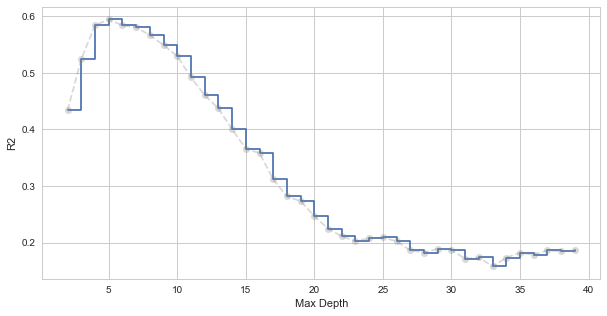

In [42]:
plt.figure(figsize=(10,5))
plt.style.use('seaborn-whitegrid')
#plt.plot(depths, scores['Test Score'])
plt.step(depths, scores['Test Score'], where='post')
plt.plot(depths, scores['Test Score'], 'o--', color='grey', alpha=0.3)
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.show()

### Re-running our Decision Tree with new max_depth

In [43]:
opt_dec_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
opt_dec_pipeline = make_pipeline(preprocessor, opt_dec_tree)
opt_dec_pipeline.fit(X_train, y_train)
opt_train_score = opt_dec_pipeline.score(X_train, y_train)
opt_test_score = opt_dec_pipeline.score(X_test, y_test)

### Tuned Decision Tree - Regression Metrics

In [44]:
#New optimal regression tree RMSE and R^2
opt_dec_tree_train_score = eval_regression(y_train, opt_dec_pipeline.predict(X_train))
opt_dec_tree_test_score = eval_regression(y_test, opt_dec_pipeline.predict(X_test))
print('Regression Tree Training Results')
print(f'RMSE Score: {opt_dec_tree_train_score[0]}')
print(f'R^2 Score: {opt_dec_tree_train_score[1]}')
print('\n')
print('Regression Tree Testing Results')
print(f'RMSE Score:  {opt_dec_tree_test_score[0]}')
print(f'R^2 Score: {opt_dec_tree_test_score[1]}')


Regression Tree Training Results
RMSE Score: 1082.6656773340972
R^2 Score: 0.6039254897160836


Regression Tree Testing Results
RMSE Score:  1057.3947626960721
R^2 Score: 0.5947470502499344


### Linear Regression and Tuned Decision Tree Regression Metrics Comparisons

In [45]:
#Linear Regression train/test and Optimal Regression Tree train/test results in Dataframe
df_index = ['Linear Reg Train Score', 'Linear Reg Test Score', 'Reg Tree Train Score', 'Reg Tree Test Score']
reg_df = pd.DataFrame(index=df_index, columns=['RMSE', 'R^2'])
reg_df.loc['Linear Reg Train Score'] = [reg_train_score[0], reg_train_score[1]]
reg_df.loc['Linear Reg Test Score'] = [reg_test_score[0], reg_test_score[1]]
reg_df.loc['Reg Tree Train Score'] = [opt_dec_tree_train_score[0], opt_dec_tree_train_score[1]]
reg_df.loc['Reg Tree Test Score'] = [opt_dec_tree_test_score[0], opt_dec_tree_test_score[1]]
reg_df

,RMSE,R^2
Linear Reg Train Score,1140.4177,0.560543
Linear Reg Test Score,1094.448675,0.565847
Reg Tree Train Score,1082.665677,0.603925
Reg Tree Test Score,1057.394763,0.594747


### Summary
Based on the regression metrics of both models, it's clear that once we addressed the overfitting issue on the Decision Tree training data, the model performed better by roughtly 45%. 

The implementation of both these models suggest that with some tuning, the Regression Tree performed slightly better than the linear regression model. The R^2 on the Regression Tree suggests that 59% of the target can be realted back to our features data. 

In conclusion, out of the two machine learning models created, the Regression Tree would be the more ideal choice in this scenario. 